In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils import shuffle
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [26]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_WIDTH)

BATCH_SIZE = 128
EPOCHS = 10

EMOTIONS = os.listdir("data")
EMOTIONS.remove("labels.csv")

In [27]:
emotions_dict = {emotion: i for i, emotion in enumerate(EMOTIONS)}
emotions_dict

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [28]:
labels_df = pd.read_csv("data/labels.csv")
labels_df.head()

,pth,label
0,anger/image0000006.jpg,surprise
1,anger/image0000007.jpg,anger
2,anger/image0000012.jpg,anger
3,anger/image0000035.jpg,fear
4,anger/image0000060.jpg,anger


In [29]:
filenames_list = []

for emotion in EMOTIONS:
    for photo in os.listdir("data/" + emotion):
        filenames_list.append(emotion + "/" + photo)

files_df = pd.DataFrame({"filename": filenames_list})
files_df.head()
    

,filename
0,anger/image0000006.jpg
1,anger/image0000007.jpg
2,anger/image0000012.jpg
3,anger/image0000035.jpg
4,anger/image0000060.jpg


In [30]:
files_df[files_df.duplicated()]

,filename


In [31]:
df = pd.merge(labels_df, files_df, left_on = "pth", right_on = "filename", how = "inner")
df.head()

,pth,label,filename
0,anger/image0000006.jpg,surprise,anger/image0000006.jpg
1,anger/image0000007.jpg,anger,anger/image0000007.jpg
2,anger/image0000012.jpg,anger,anger/image0000012.jpg
3,anger/image0000035.jpg,fear,anger/image0000035.jpg
4,anger/image0000060.jpg,anger,anger/image0000060.jpg


In [32]:
images = []
labels = []

for row in tqdm(df.itertuples()):
    img = cv2.imread("data" + "/" + row[1])

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    resized_img = cv2.resize(img, IMAGE_SIZE)
    
    if np.max(resized_img) > 1:
        norm_img = resized_img / 255
    
    images.append(norm_img)
    labels.append(emotions_dict[row[2]])

images = np.array(images)
labels = np.array(labels)

31002it [06:45, 76.54it/s] 


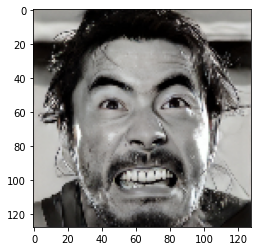

In [33]:
plt.imshow(images[3])

In [34]:
images[3].shape

(128, 128, 3)

In [35]:
images, labels = shuffle(images, labels, random_state = 42)

In [40]:
y_encoder = OneHotEncoder()
labels = y_encoder.fit_transform(labels.reshape(-1, 1))
labels = labels.toarray()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [42]:
y_train.shape

(26351, 8)

In [44]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [45]:
y_train_2.shape

(21080, 8)

In [46]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding = 'Same', input_shape=(IMAGE_WIDTH, IMAGE_WIDTH, CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

model.add(Conv2D(24, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(len(emotions_dict), activation='softmax'))

model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 24)        3480      
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 24)      

In [48]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [49]:
history = model.fit(X_train_2, 
          y_train_2, 
          epochs = EPOCHS * 10,
          batch_size = BATCH_SIZE,
          validation_data=(X_val, y_val),
          callbacks = [earlystop]
          )

Epoch 1/100
165/165 [==============================] - 149s 884ms/step - loss: 2.1173 - accuracy: 0.2810 - val_loss: 5.1587 - val_accuracy: 0.1227
Epoch 2/100
165/165 [==============================] - 132s 799ms/step - loss: 1.5792 - accuracy: 0.4224 - val_loss: 2.1146 - val_accuracy: 0.1975
Epoch 3/100
165/165 [==============================] - 134s 815ms/step - loss: 1.3811 - accuracy: 0.4935 - val_loss: 1.5948 - val_accuracy: 0.3994
Epoch 4/100
165/165 [==============================] - 151s 913ms/step - loss: 1.2642 - accuracy: 0.5289 - val_loss: 1.2929 - val_accuracy: 0.5213
Epoch 5/100
165/165 [==============================] - 141s 851ms/step - loss: 1.1686 - accuracy: 0.5666 - val_loss: 1.2378 - val_accuracy: 0.5265
Epoch 6/100
165/165 [==============================] - 129s 780ms/step - loss: 1.1085 - accuracy: 0.5865 - val_loss: 1.2101 - val_accuracy: 0.5595
Epoch 7/100
165/165 [==============================] - 128s 777ms/step - loss: 1.0472 - accuracy: 0.6104 - val_loss: 1

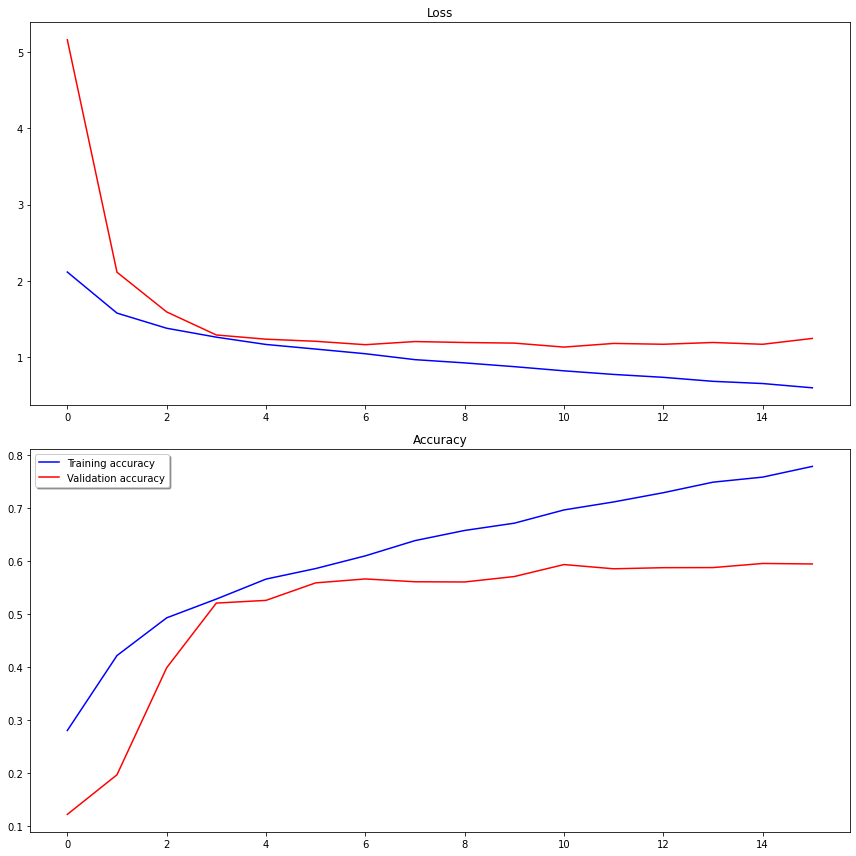

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label = "Training loss")
ax1.plot(history.history['val_loss'], color='r', label = "Validation loss")
ax1.set_title("Loss")

ax2.plot(history.history['accuracy'], color='b', label = "Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label = "Validation accuracy")
ax2.set_title("Accuracy")


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [58]:
model.save('models/model_1.h5')

In [59]:
test_loss = model.evaluate(X_test, y_test)
test_loss

146/146 [==============================] - 8s 56ms/step - loss: 1.2123 - accuracy: 0.6048


[1.212261438369751, 0.604816198348999]

In [74]:
y_pred = model.predict(X_test)

146/146 [==============================] - 8s 53ms/step


In [69]:
y_pred[0]

array([8.4907551e-05, 1.8138182e-05, 3.5788056e-05, 9.8619878e-01,
       6.3102839e-06, 6.5586228e-06, 2.3122145e-06, 1.3647161e-02],
      dtype=float32)

In [90]:
inv_emotions_dict = {v: k for k, v in emotions_dict.items()}
inv_emotions_dict

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [85]:
y_pred_cat = [inv_emotions_dict[list(pred).index(max(list(pred)))] for pred in y_pred]
y_test_cat= [inv_emotions_dict[list(pred).index(max(list(pred)))] for pred in y_test]

In [86]:
y_pred_cat[0]

'fear'

<AxesSubplot:>

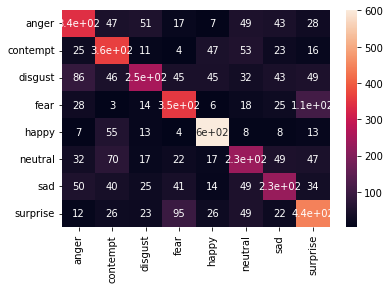

In [88]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test_cat, y_pred_cat)
sns.heatmap(confusion_mtx, annot=True, xticklabels=emotions_dict.keys(), yticklabels=emotions_dict.keys())